# **A. Introduction**

In this assignment, the objective is to develop a deep learning system capable of classifying human actions from still images, addressing challenges in human action recognition (HAR). The system should predict two key attributes: the action class (from 40 possible categories) and whether there is more than one person present in the image. This system has broad applications in video surveillance, human-machine interfaces, and identity recognition. The development is based on convolutional neural networks (CNNs) using TensorFlow 2 and Keras.

# **B. Problem Definition**

The goal is to build a single neural network model that takes an image as input and predicts two outputs:
*   The action performed by a person (categorized into 40 classes)
*   Whether there is more than one person in the image



# **C.   Data Processing and Exploration**


Before model training, it is essential to set up a robust evaluation framework to ensure that the model's performance is fairly and accurately assessed. This involves splitting the data into training, validation, and testing datasets. The training set is used to train the model, the validation set is used to tune hyperparameters, and the test set provides an unbiased evaluation of the model's performance.

**Rationale:** A typical split of 70% training, 15% validation, and 15% testing ensures sufficient data for training while preserving enough data to validate the model and assess generalization performance.

In [ ]:
%pip install -q -U keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.7 MB/s eta 0:00:00


In [77]:
import os
import zipfile
import pandas as pd
import numpy as np
import keras_tuner as kt
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import imageio
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from pathlib import Path
from time import strftime
import uuid
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import Xception, MobileNetV2
from PIL import Image

## **Connect data file**



*   ***Mounting Google Drive:*** The code uses drive.mount('/content/drive') to mount Google Drive into the Colab environment, enabling access to files stored in the cloud. This is essential for handling large datasets and persistent storage in a seamless and reliable way, commonly used in Colab for large-scale data analysis.

*   ***Setting the Data Path:*** The data_path variable specifies the location of the dataset in Google Drive. This makes the code more flexible and easier to maintain, as changes to the data location can be made by simply updating this variable.

*   ***Changing the Working Directory:*** Using os.chdir(data_path), the working directory is set to the specified data path. This allows for easier file handling by making all subsequent operations relative to this directory, reducing the need for full path specifications and minimizing errors.

*   ***Listing the Contents of the Current Directory:*** The command os.listdir() lists the files in the current directory, confirming that the working directory is set correctly and that the necessary data files are present. This step acts as a checkpoint before proceeding with further data processing.


In [ ]:
# Unzip image file (only if the image file hasn't been unzipped)
!unzip -q Images.zip

The code loads two CSV files into Pandas DataFrames: train_data for training and future_data for future predictions. Besides, the 'FilePath' column is added to both DataFrames to store the full path to each image file. The paths are constructed by joining a common directory (image_dir) with the individual filenames from the FileName column. By that way, constructing full paths for each image ensures that the images can be easily accessed later, facilitating image loading for training and prediction. This approach centralizes file handling and ensures consistency, reducing the likelihood of errors when accessing image files.

In [96]:
train_data = pd.read_csv('train_data_2024.csv')
future_data = pd.read_csv('future_data_2024.csv')

image_dir = './Images/'
# Get all file paths of the images
train_data['FilePath'] = train_data['FileName'].apply(lambda x: os.path.join(image_dir, x))
future_data['FilePath'] = future_data['FileName'].apply(lambda x: os.path.join(image_dir, x))

In [ ]:
future_data.head()

,FileName,FilePath
0,Img_1963.jpg,./Images/Img_1963.jpg
1,Img_7244.jpg,./Images/Img_7244.jpg
2,Img_6218.jpg,./Images/Img_6218.jpg
3,Img_7703.jpg,./Images/Img_7703.jpg
4,Img_6318.jpg,./Images/Img_6318.jpg


In [ ]:
train_data.head()

,FileName,Class,MoreThanOnePerson,HighLevelCategory,FilePath
0,Img_460.jpg,blowing_bubbles,YES,Social_LeisureActivities,./Images/Img_460.jpg
1,Img_8152.jpg,blowing_bubbles,YES,Social_LeisureActivities,./Images/Img_8152.jpg
2,Img_9056.jpg,jumping,YES,Sports_Recreation,./Images/Img_9056.jpg
3,Img_3880.jpg,pushing_a_cart,YES,OutdoorActivities,./Images/Img_3880.jpg
4,Img_3168.jpg,writing_on_a_book,NO,Artistic_MusicalActivities,./Images/Img_3168.jpg


In [ ]:
RANDOM_STATE = 42
tf.random.set_seed(RANDOM_STATE)

## **Preprocess the data**

By examining the number of distinct values in the 'Class' column, you ensure that the dataset is correctly labeled for training. If the result deviates from 40, it may indicate missing or extra classes that could impact model performance.

In addition to verifying the number of classes, it's important to note that the development data includes three labels: 'Class', 'MoreThanOnePerson', and 'HighLevelCategory', with 'FileName' being excluded from predictions. For the primary model, you only need to predict the 'Class' and 'MoreThanOnePerson' labels. The 'HighLevelCategory' label, although not necessary for the main prediction task, could be useful as an auxiliary output layer. Integrating 'HighLevelCategory' in this way might help in normalizing the model or improving its performance by providing additional contextual information.

In [ ]:
# Verify if the quantity of classes aligns with the specifications by confirming that there are indeed 40 classes in total
train_data['Class'].nunique()

40

By counting the number of non-null entries in the 'FileName' column, this line provides the total count of data points available for training. This count is essential for understanding the size of your dataset and ensuring that you have enough instances to build and evaluate your model effectively.

In [ ]:
# Check how many instances
train_data['FileName'].count()

4500

It is also important to note that the future_data does not contain any labels, rendering it unsuitable for evaluation purposes. As a result, the data from the train_data_2024.csv file will be used and split into training, testing, and validation datasets. Furthermore, it has been confirmed that the train data contains the correct number of unique classes, aligning with the model's requirements and ensuring that the dataset is appropriately structured for training and evaluation.

## **Validate Images**

In [ ]:
# Check if any Filename overlap between 2 data file
train_data['FileName'].isin(future_data['FileName']).sum()

0

This count helps to detect potential data leakage, which occurs if the same images are present in both datasets. Ensuring that there are no overlapping filenames is crucial for maintaining the integrity of your training and evaluation processes, as it prevents the possibility of the model being inadvertently trained or tested on duplicate data.

In [ ]:
# Get the size of an image given its filepath
def image_dimensions(filepath):
    image = imageio.imread(filepath)
    width, height = image.shape[1], image.shape[0]
    return width, height

# Check the sizes of all images listed in the 'FileName' column of a DataFrame
def get_image_sizes(data):
    # Initialize an empty list to store the image sizes
    image_sizes = []

    # Loop over each filename in the 'FileName' column of the data
    for filename in data['FileName']:
        # Construct the full path to the image file
        image_path = os.path.join('Images', filename)
        print(image_path)

        # Get the dimensions of the image
        dimensions = image_dimensions(image_path)

        # Append the dimensions to the list
        image_sizes.append(dimensions)

    return image_sizes

In [ ]:
sizes = get_image_sizes(train_data)

Images\Img_460.jpg
Images\Img_8152.jpg
Images\Img_9056.jpg
Images\Img_3880.jpg
Images\Img_3168.jpg
Images\Img_8609.jpg
Images\Img_3838.jpg
Images\Img_1699.jpg
Images\Img_8543.jpg
Images\Img_1980.jpg
Images\Img_1312.jpg
Images\Img_4514.jpg
Images\Img_3866.jpg
Images\Img_1665.jpg
Images\Img_4231.jpg
Images\Img_8675.jpg
Images\Img_1137.jpg
Images\Img_5918.jpg
Images\Img_951.jpg
Images\Img_5516.jpg


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_20244\1066270814.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filepath)


Images\Img_8478.jpg
Images\Img_5152.jpg
Images\Img_2000.jpg
Images\Img_8656.jpg
Images\Img_5416.jpg
Images\Img_4513.jpg
Images\Img_1342.jpg
Images\Img_6016.jpg
Images\Img_7130.jpg
Images\Img_5929.jpg
Images\Img_911.jpg
Images\Img_2077.jpg
Images\Img_949.jpg
Images\Img_997.jpg
Images\Img_991.jpg
Images\Img_4408.jpg
Images\Img_3907.jpg
Images\Img_3098.jpg
Images\Img_7745.jpg
Images\Img_9239.jpg
Images\Img_1290.jpg
Images\Img_1018.jpg
Images\Img_5533.jpg
Images\Img_793.jpg
Images\Img_8428.jpg
Images\Img_2875.jpg
Images\Img_3195.jpg
Images\Img_2888.jpg
Images\Img_2537.jpg
Images\Img_6433.jpg
Images\Img_3202.jpg
Images\Img_6556.jpg
Images\Img_337.jpg
Images\Img_9020.jpg
Images\Img_9106.jpg
Images\Img_3269.jpg
Images\Img_379.jpg
Images\Img_4799.jpg
Images\Img_9344.jpg
Images\Img_2542.jpg
Images\Img_9114.jpg
Images\Img_8489.jpg
Images\Img_3469.jpg
Images\Img_4438.jpg
Images\Img_3284.jpg
Images\Img_4934.jpg
Images\Img_2179.jpg
Images\Img_7734.jpg
Images\Img_5645.jpg
Images\Img_8158.jpg
Images\

The code snippet 'image_dimensions(filepath)' defines a function to retrieve the dimensions of an image given its file path. By using 'imageio.imread(filepath)', the function loads the image, and image.shape provides its width and height. The function returns these dimensions, which are essential for analyzing and ensuring consistency in image sizes within the dataset.

To check the sizes of all images listed in the 'FileName' column of a DataFrame, the function 'get_all_image_sizes(data)' is used. This function iterates over each filename, constructs the full path to the image using 'os.path.join('Images', filename)', and retrieves the image dimensions through the image_dimensions function. The sizes are then collected in a list. This approach allows you to systematically analyze the dimensions of all images in the dataset, which is crucial for preprocessing and ensuring that all images conform to the required specifications for model training.

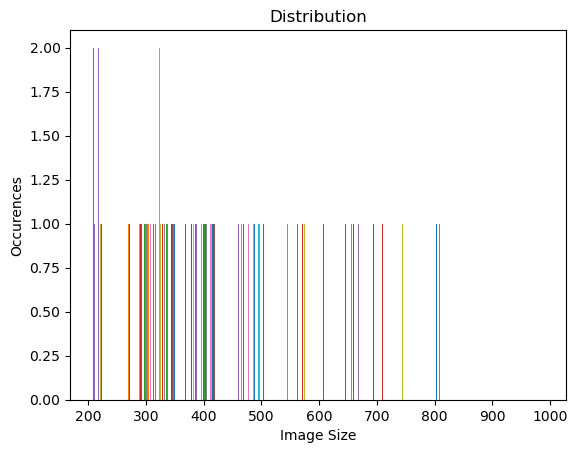

In [ ]:
# Plot the sizes
plt.hist(sizes, bins=10)
plt.xlabel('Image Size')
plt.ylabel('Occurences')
plt.title('Distribution')
plt.show()

The plot illustrates the distribution of image sizes within your dataset. The following key points can be concluded:


*   **Sparse Distribution:** The histogram shows that the image sizes are sparsely distributed across different values. This is indicated by the tall, thin lines corresponding to individual image sizes, suggesting that there are not many images of the same size.

*   **No Common Image Size:** Unlike typical datasets where a peak or cluster might indicate a common or predominant image size, this dataset lacks such clustering. This could suggest significant variation in the dimensions of images.

*   **Implications for Preprocessing:**

  *   ***Resizing Required:*** Given the variety in image sizes, it's likely that resizing images to a uniform dimension will be necessary before feeding them into a deep learning model, especially we are planning to use a pre-trained Convolutional Neural Network (CNN).

  *   ***Memory and Performance Consideration:*** The variation in image sizes might also impact memory usage and processing time, making it even more important to standardize image dimensions.


*   **Outliers:** There might be outliers present with very large or very small dimensions compared to the rest. These should be handled carefully, as they can skew model training if not properly addressed.


















## **Imbalance of the Data**

The distribution of classes was considered, and techniques like class weighting or oversampling could be considered if significant imbalance is found.

To analyze the distribution of occurrences within the dataset, the code snippet 'grouped_counts = train_data.groupby(['Class', 'MoreThanOnePerson']).size().reset_index(name='Count')' groups the data by the 'Class' and 'MoreThanOnePerson' columns, then counts the number of occurrences for each combination. This grouping is useful for understanding how many instances fall into each class and whether they contain more than one person.

Following this, 'the pivot_table = grouped_counts.pivot(index='Class', columns='MoreThanOnePerson', values='Count').fillna(0)' reshapes the grouped data into a format suitable for plotting. By pivoting the table, you can create a stacked bar chart to visually represent the distribution of 'MoreThanOnePerson' within each 'Class'. The plotting code 'ax = pivot_table.plot(kind='bar', stacked=True, figsize=(10, 6))' generates this chart, with 'ax.set_title()', 'ax.set_xlabel()', 'ax.set_ylabel()', and 'ax.set_xticklabels()' enhancing readability and presentation. The final result is a clear visualization showing how many images in each class involve more than one person, facilitating a better understanding of the dataset's composition.

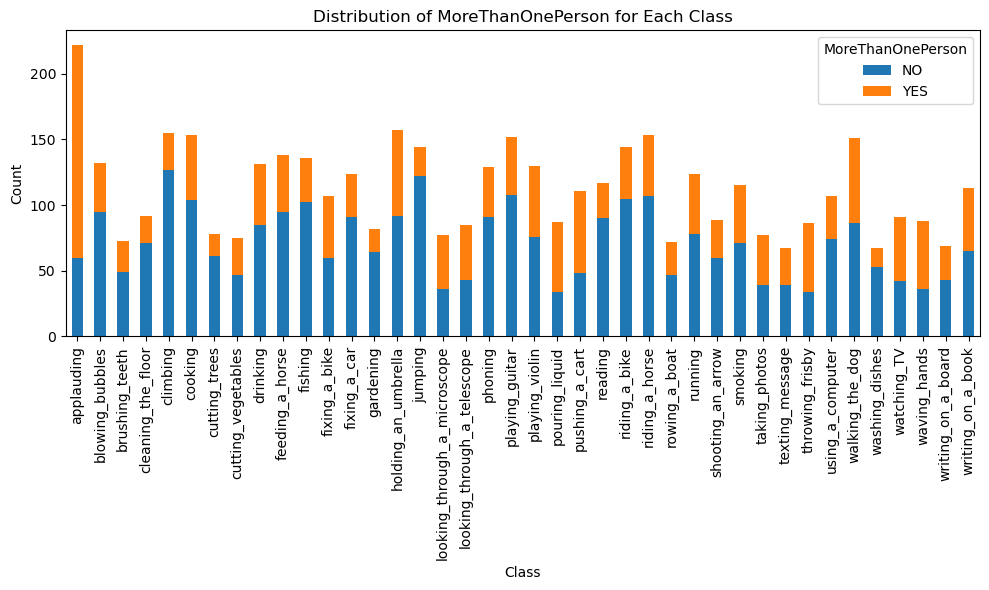

In [ ]:
# Group the data and count occurrences
grouped_counts = train_data.groupby(['Class', 'MoreThanOnePerson']).size().reset_index(name='Count')

# Pivot the table to make it suitable for plotting
pivot_table = grouped_counts.pivot(index='Class', columns='MoreThanOnePerson', values='Count').fillna(0)

# Plot the data using the `plot` method
ax = pivot_table.plot(kind='bar', stacked=True, figsize=(10, 6))  # Adjust figsize for better visualization
ax.set_title('Distribution of MoreThanOnePerson for Each Class')
ax.set_xlabel('Class')
ax.set_ylabel('Count')
ax.set_xticklabels(pivot_table.index, rotation=90)  # Rotate x-axis labels for readability
ax.legend(title='MoreThanOnePerson')
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

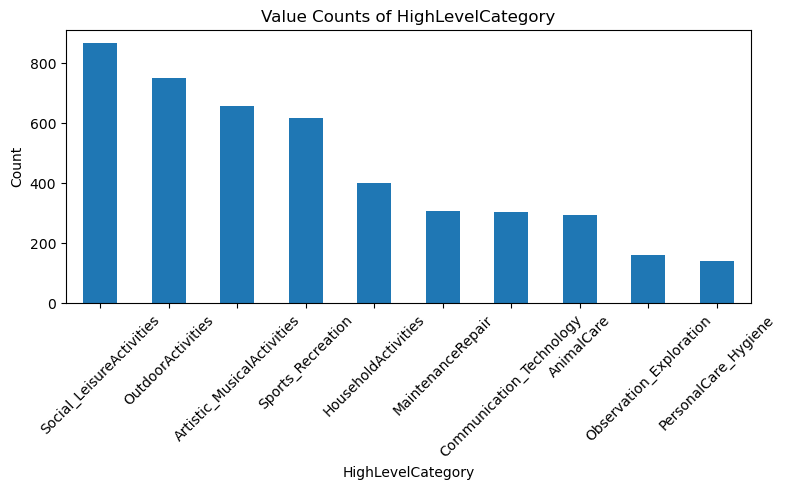

In [ ]:
# Count occurrences of each category in 'HighLevelCategory'
category_counts = train_data['HighLevelCategory'].value_counts()

# Plot the bar chart using the `plot` method
ax = category_counts.plot(kind='bar', figsize=(8, 5))  # Adjust figsize for visualization
ax.set_title('Value Counts of HighLevelCategory')
ax.set_xlabel('HighLevelCategory')
ax.set_ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if needed
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

**Conclusion of the plots**

The imbalance in the MoreThanOnePerson occurrences and the uneven distribution of classes and categories might affect the model’s ability to generalize across different scenarios. This imbalance could be due to varying scene complexities or contexts within each class. To address these issues, several strategies might be employed:

*   **Data Augmentation:** Implementing data augmentation techniques can help balance the occurrences within each class while maintaining a balanced distribution of the MoreThanOnePerson label.
*   **Class Weights Adjustment:** Applying more weight to under-represented classes and less weight to over-represented classes can help mitigate the effects of class imbalance.

These approaches should be considered after evaluating the performance of a baseline model to determine the most effective method for balancing the dataset and improving model accuracy.


## **Prepare data for training**

The current dataset consists of image file names and labels stored as strings. For training a deep learning model, the data must be transformed into a format that can be processed by the model.

### *Preparing Images*

In preparing the data for training, I started by ensuring uniformity across images, setting the dimensions to 224x224, which is commonly used in pre-trained models like ResNet and VGG. This decision is rooted in literature, as standardizing image size allows for better compatibility with convolutional neural networks (CNNs), which expect fixed-size inputs. Moreover, keeping a consistent image resolution minimizes computation during resizing operations while ensuring no data is lost from inconsistent dimensions. Setting a random seed ensures the reproducibility of results, a best practice in machine learning to maintain consistency across different runs, and avoid variability in model performance.

In [54]:
# Define the image size for uniformity and compatibility with pre-trained models
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
RANDOM_SEED = 42

### *Encoding Class Labels and Binary Labels*

To prepare the target labels, the class labels were factorized to convert them into integers, which is required by the neural network's categorical output layer. Additionally, the MoreThanOnePerson column was converted into binary values (1 for "YES" and 0 for "NO"). This binary label is crucial for the secondary output of the model, which is designed to predict whether multiple people are present in the image.

In [98]:
# Encode the 'Class' column
train_data['Class'], class_mapping = pd.factorize(train_data['Class'])

# Convert 'MoreThanOnePerson' column to binary values (1 for 'YES' and 0 for 'NO')
train_data['MoreThanOnePerson'] = train_data['MoreThanOnePerson'].apply(lambda x: 1 if x == 'YES' else 0)

In [99]:
# Create a mapping for 'MoreThanOnePerson'
binary_mapping = {1: 'YES', 0: 'NO'}

# Save class mapping (index to class name)
class_mapping = {index: label for index, label in enumerate(class_mapping)}

### *Preprocessing Image Data*

In [101]:
def preprocess_image(path, lbl=None):
    """
    Loads and preprocesses an image from a given file path.

    Args:
        path (tf.Tensor): Path to the image file.
        lbl (dict, optional): Dictionary containing labels. Defaults to None.

    Returns:
        tf.Tensor or tuple: Preprocessed image, and optionally labels.
    """
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMAGE_WIDTH, IMAGE_HEIGHT])
    img = tf.cast(img, tf.float32) / 255.0  # Normalize to [0,1]

    if lbl is not None:
        return img, lbl
    else:
        return img

A stratified split was used to partition the dataset into training and testing sets, ensuring that the class distribution remains balanced across both sets. Stratified sampling is important because it ensures that each class is proportionally represented, preventing bias in the model toward the majority class.

In [102]:
# Split the dataset into training and testing sets
train_set, test_set = train_test_split(
    train_data,
    test_size=0.3,
    random_state=RANDOM_SEED,
    stratify=train_data['Class']
)

val_set, test_set = train_test_split(
    test_set,
    test_size=0.5,
    random_state=RANDOM_SEED,
    stratify=test_set['Class']
)

print(f"Training samples: {len(train_set)}, Testing samples: {len(test_set)}, Validation samples: {len(val_set)}")

Training samples: 3150, Testing samples: 675, Validation samples: 675


For efficient data handling, a custom function was defined to create TensorFlow datasets. This function loads image file paths, applies necessary preprocessing steps such as resizing and normalization, and prepares the data for training by batching and shuffling. Using the tf.data.Dataset API is recommended for handling large datasets in TensorFlow, as it provides optimized input pipelines that support multi-threaded execution and prefetching, minimizing latency during training. The dataset is shuffled only during training to introduce randomness in each epoch, which prevents the model from learning any spurious patterns from the order of the data. Batching helps balance memory consumption and speeds up training, while prefetching ensures that the GPU is constantly fed with data without unnecessary wait times.

In [103]:
# Function to create TensorFlow datasets
def create_tf_dataset(file_paths, labels=None, shuffle_buffer=1000, batch_size=32, is_training=True):
    """
    Creates a TensorFlow dataset from file paths and labels.

    Args:
        file_paths (pd.Series): Series containing file paths.
        labels (dict, optional): Dictionary containing labels. Defaults to None.
        shuffle_buffer (int, optional): Buffer size for shuffling. Defaults to 1000.
        batch_size (int, optional): Batch size. Defaults to 32.
        is_training (bool, optional): Whether the dataset is for training. Defaults to True.

    Returns:
        tf.data.Dataset: Prepared TensorFlow dataset.
    """
    if labels:
        dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
        dataset = dataset.map(lambda x, y: preprocess_image(x, y), num_parallel_calls=tf.data.AUTOTUNE)
    else:
        dataset = tf.data.Dataset.from_tensor_slices(file_paths)
        dataset = dataset.map(lambda x: preprocess_image(x), num_parallel_calls=tf.data.AUTOTUNE)

    if is_training and labels:
        dataset = dataset.shuffle(buffer_size=shuffle_buffer)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

The labels for both categorical (class) and binary (MoreThanOnePerson) outputs were prepared as dictionaries, making it easy to handle the multi-output nature of the model. This approach allows for the simultaneous prediction of two tasks, a strategy known as multi-task learning, which is efficient as it allows shared representation learning and can lead to better generalization. The training, validation, and future datasets were created, ensuring proper handling of both the labeled and unlabeled data.

In [104]:
# Prepare labels as dictionaries
train_labels = {
    'categorical_output': train_set['Class'].values,
    'binary_output': train_set['MoreThanOnePerson'].values
}

test_labels = {
    'categorical_output': test_set['Class'].values,
    'binary_output': test_set['MoreThanOnePerson'].values
}

val_labels = {
    'categorical_output': val_set['Class'].values,
    'binary_output': val_set['MoreThanOnePerson'].values
}

# Create TensorFlow datasets
training_dataset = create_tf_dataset(
    file_paths=train_set['FilePath'],
    labels=train_labels,
    shuffle_buffer=1000,
    batch_size=32,
    is_training=True
)

testing_dataset = create_tf_dataset(
    file_paths=test_set['FilePath'],
    labels=test_labels,
    shuffle_buffer=0,  # No shuffling for validation
    batch_size=32,
    is_training=False
)

validation_dataset = create_tf_dataset(
    file_paths=val_set['FilePath'],
    labels=val_labels,
    shuffle_buffer=0,  # No shuffling for validation
    batch_size=32,
    is_training=False
)

future_dataset = create_tf_dataset(
    file_paths=future_data['FilePath'],
    labels=None,
    shuffle_buffer=0,
    batch_size=32,
    is_training=False
)

### *Inspect dataset to check if loaded correctly*

In [105]:
class_mapping

{0: 'blowing_bubbles',
 1: 'jumping',
 2: 'pushing_a_cart',
 3: 'writing_on_a_book',
 4: 'walking_the_dog',
 5: 'feeding_a_horse',
 6: 'smoking',
 7: 'looking_through_a_telescope',
 8: 'fishing',
 9: 'playing_guitar',
 10: 'applauding',
 11: 'cleaning_the_floor',
 12: 'riding_a_bike',
 13: 'cutting_vegetables',
 14: 'cutting_trees',
 15: 'phoning',
 16: 'gardening',
 17: 'holding_an_umbrella',
 18: 'cooking',
 19: 'texting_message',
 20: 'fixing_a_car',
 21: 'reading',
 22: 'riding_a_horse',
 23: 'throwing_frisby',
 24: 'waving_hands',
 25: 'climbing',
 26: 'writing_on_a_board',
 27: 'running',
 28: 'washing_dishes',
 29: 'using_a_computer',
 30: 'drinking',
 31: 'fixing_a_bike',
 32: 'watching_TV',
 33: 'looking_through_a_microscope',
 34: 'playing_violin',
 35: 'brushing_teeth',
 36: 'shooting_an_arrow',
 37: 'pouring_liquid',
 38: 'rowing_a_boat',
 39: 'taking_photos'}

In [106]:
# Function to visualize a batch of images and labels
def inspect_dataset(dataset, dataset_name='Dataset'):
    """
    Inspects a single batch from the dataset by printing shapes and displaying an image.

    Args:
        dataset (tf.data.Dataset): TensorFlow dataset to inspect.
        dataset_name (str, optional): Name of the dataset. Defaults to 'Dataset'.
    """
    for batch in dataset.take(1):
        if isinstance(batch, tuple):
            images, labels = batch
            print(f"{dataset_name} - Images shape: {images.shape}")
            print(f"{dataset_name} - Categorical Labels shape: {labels['categorical_output'].shape}")
            print(f"{dataset_name} - Binary Labels shape: {labels['binary_output'].shape}")
            plt.imshow(images[0].numpy())
            plt.title(f"{dataset_name} - {class_mapping[labels['categorical_output'][0].numpy()]}")
            plt.axis('off')
            plt.show()
        else:
            images = batch
            print(f"{dataset_name} - Images shape: {images.shape}")
            plt.imshow(images[0].numpy())
            plt.title(f"{dataset_name} - Example Image")
            plt.axis('off')
            plt.show()

Test Dataset - Images shape: (32, 224, 224, 3)
Test Dataset - Categorical Labels shape: (32,)
Test Dataset - Binary Labels shape: (32,)


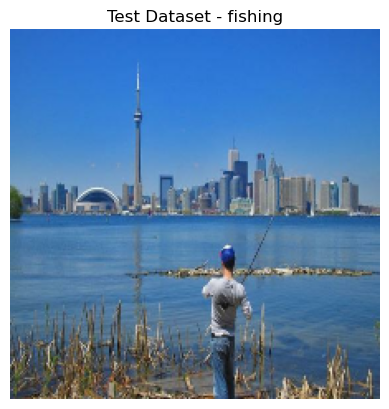

In [107]:
# Inspect the validation dataset
inspect_dataset(validation_dataset, dataset_name='Test Dataset')

Train Dataset - Images shape: (32, 224, 224, 3)
Train Dataset - Categorical Labels shape: (32,)
Train Dataset - Binary Labels shape: (32,)


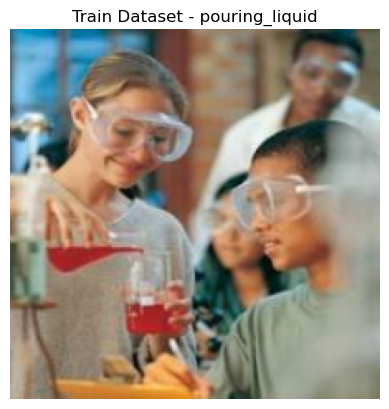

In [108]:
# Inspect the training dataset
inspect_dataset(training_dataset, dataset_name='Train Dataset')

Validation Dataset - Images shape: (32, 224, 224, 3)
Validation Dataset - Categorical Labels shape: (32,)
Validation Dataset - Binary Labels shape: (32,)


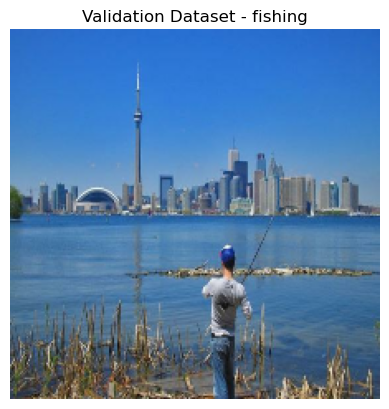

In [109]:
# Inspect the validation dataset
inspect_dataset(validation_dataset, dataset_name='Validation Dataset')

Future Dataset - Images shape: (32, 224, 224, 3)


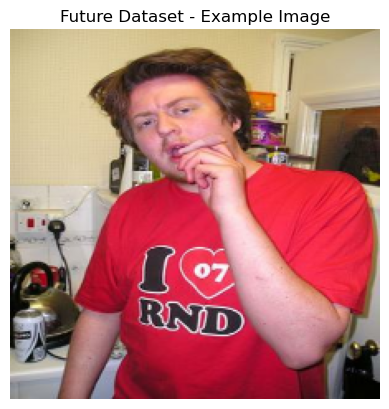

In [110]:
# Inspect the future dataset
for future_batch in future_dataset.take(1):
    print(f"Future Dataset - Images shape: {future_batch.shape}")
    plt.imshow(future_batch[0].numpy())
    plt.title("Future Dataset - Example Image")
    plt.axis('off')
    plt.show()

# **D. Baseline Model**

#### Creating Helper functions

To facilitate the training process, utility functions were developed for model callbacks, including EarlyStopping and learning rate adjustments. These callbacks help in optimizing the model by stopping the training early when no further improvements are observed.

In [31]:
# Utility function to set up callbacks for model training
def create_callbacks(callback_list=[]):
    """
    Prepares a list of callbacks for model training, including EarlyStopping.

    Args:
        callback_list (list, optional): List of additional callbacks to include. Defaults to an empty list.

    Returns:
        list: A list of configured callbacks.
    """
    # Initialize a list for the final callbacks
    final_callbacks = []

    # Add any provided callbacks
    if callback_list:
        final_callbacks.extend(callback_list)

    # Add EarlyStopping callback with patience and best weights restoration
    early_stop = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
    final_callbacks.append(early_stop)

    return final_callbacks

In [32]:
def plot_training_history(history):
    epochs = range(1, len(history.history['loss']) + 1)

    # Extract metrics from history object
    train_class_loss = history.history.get('categorical_output_loss', [])
    val_class_loss = history.history.get('val_categorical_output_loss', [])
    train_person_loss = history.history.get('binary_output_loss', [])
    val_person_loss = history.history.get('val_binary_output_loss', [])

    # Plot Loss for Class Output
    plt.figure(figsize=(7, 6))
    plt.plot(epochs, train_class_loss, 'b-', label='Training Loss (Class)')
    plt.plot(epochs, val_class_loss, 'r-', label='Validation Loss (Class)')
    plt.title('Training and Validation Loss (Class Output)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot Loss for Person Output
    plt.figure(figsize=(7, 6))
    plt.plot(epochs, train_person_loss, 'g--', label='Training Loss (Person)')
    plt.plot(epochs, val_person_loss, 'm--', label='Validation Loss (Person)')
    plt.title('Training and Validation Loss (Person Output)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [33]:
def visualize_predictions(model, dataset, class_mapping, num_images=9):
    # Create a mapping from class indices to class names
    idx_to_class = {index: class_name for index, class_name in enumerate(class_mapping)}

    # Prepare the figure for displaying images
    plt.figure(figsize=(12, 12))
    image_count = 0

    for images, labels in dataset.take(1):  # Take one batch from the dataset
        predictions = model.predict(images)

        for i in range(min(num_images, len(images))):
            ax = plt.subplot(3, 3, image_count + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.axis('off')

            # Get predicted class and person count
            predicted_class = np.argmax(predictions[0][i])
            predicted_person_label = "YES" if predictions[1][i] > 0.5 else "NO"

            if labels is not None:
                true_class = np.argmax(labels[0][i].numpy())
                true_person_label = "YES" if labels[1][i].numpy() == 1 else "NO"
                title = f'True: {idx_to_class[true_class]} | {true_person_label}\nPred: {idx_to_class[predicted_class]} | {predicted_person_label}'
            else:
                title = f'Predicted: {idx_to_class[predicted_class]} | {predicted_person_label}'

            plt.title(title)

            image_count += 1
            if image_count >= num_images:
                break

        if image_count >= num_images:
            break

    plt.tight_layout()
    plt.show()



In [34]:
def plot_confusion_matrices(model, dataset, class_names):
    actual_classes = []
    actual_person_count = []
    predicted_classes = []
    predicted_person_count = []

    # Iterate through the dataset to gather true and predicted labels
    for imgs, lbls in dataset:
        actual_classes.extend(lbls['categorical_output'].numpy())  # True class labels
        actual_person_count.extend(lbls['binary_output'].numpy())  # True binary labels for MoreThanOnePerson
        preds = model.predict(imgs, verbose=0)
        predicted_classes.extend(tf.argmax(preds[0], axis=1).numpy())
        predicted_person_count.extend([1 if p >= 0.5 else 0 for p in preds[1]])

    # Create a subplot with 2 axes for two confusion matrices
    fig, ax = plt.subplots(1, 2, figsize=(14, 8))

    # Confusion matrix for class predictions
    class_conf_matrix = confusion_matrix(actual_classes, predicted_classes)

    # Generate the list of class names using the class_names mapping
    labels = [class_names[i] for i in range(len(class_names))]

    # Plot heatmap for class prediction confusion matrix
    sns.heatmap(class_conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels, ax=ax[0])
    ax[0].set_title('Confusion Matrix - Class Predictions')
    ax[0].set_ylabel('True Class')
    ax[0].set_xlabel('Predicted Class')

    # Confusion matrix for MoreThanOnePerson predictions
    person_conf_matrix = confusion_matrix(actual_person_count, predicted_person_count)

    # Plot heatmap for MoreThanOnePerson prediction confusion matrix
    sns.heatmap(person_conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=["NO", "YES"], yticklabels=["NO", "YES"], ax=ax[1])
    ax[1].set_title('Confusion Matrix - MoreThanOnePerson Predictions')
    ax[1].set_ylabel('True Label')
    ax[1].set_xlabel('Predicted Label')

    # Ensure layout is neat
    plt.tight_layout()
    plt.show()

#### Creating Baseline Models

The first model created was a simple convolutional neural network (CNN) with four convolutional layers. This baseline model aimed to classify human actions from still images and determine if more than one person is present.

In [ ]:
def build_baseline_model(units=[16, 32, 64, 64], num_classes=40):
    # Input layer
    inputs = tf.keras.layers.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))

    # Convolutional layers with max pooling
    x = tf.keras.layers.Conv2D(units[0], (3, 3), activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)

    x = tf.keras.layers.Conv2D(units[1], (3, 3), activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)

    x = tf.keras.layers.Conv2D(units[2], (3, 3), activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)

    # Flatten layer
    x = tf.keras.layers.Flatten()(x)

    # Fully connected layer
    x = tf.keras.layers.Dense(units[3], activation='relu')(x)

    # Output layers
    class_output = tf.keras.layers.Dense(num_classes, activation='softmax', name='categorical_output')(x)  # Class output
    person_output = tf.keras.layers.Dense(1, activation='sigmoid', name='binary_output')(x)  # Person output

    # Create and return the model
    model = tf.keras.models.Model(inputs=inputs, outputs=[class_output, person_output])

    return model

In [ ]:
# Create the baseline model
baseline_model = build_baseline_model()

# Compile the model
baseline_model.compile(
    optimizer='adam',
    loss={
        'categorical_output': 'sparse_categorical_crossentropy',  # Loss function for class classification
        'binary_output': 'binary_crossentropy'       # Loss function for binary classification
    },
    metrics={
        'categorical_output': 'accuracy',  # Metric for class classification
        'binary_output': tf.keras.metrics.Precision(name='precision')   # Metric for binary classification
    }
)

# Display the model summary
baseline_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 222, 222, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 111, 111, 16  0           ['conv2d[0][0]']                 
                                )                                                             

*  **Parameter Count**
  *   ***Total Parameters:*** 2,795,209
  *   The majority of the parameters (around 2.7 million) are in the dense layer, which connects the high-dimensional feature map to the output layer.

*   **Performance Observations**
  *   ***Overfitting:*** After training the model for 10 epochs, the validation performance started to degrade compared to the training performance. This suggests that the model was overfitting, meaning it learned the patterns in the training data too well and failed to generalize to new, unseen data.
  *   ***Reason for Overfitting:***
      *  *Limited Data:* The dataset was relatively small, and the model had enough capacity (large number of parameters) to memorize the training data, which led to overfitting.
      *   *Complexity of Model:* Although the model was relatively simple in its architecture, the fully connected layer with 2.7 million parameters provided too much capacity for the given task, making it easy to overfit the small dataset.

To improve the model’s performance and prevent overfitting, transfer learning with pre-trained networks was applied, followed by the introduction of attention modules.



# **E. Training Model**

For training the baseline model, the following steps were taken to optimize and evaluate its performance. In order to adjust the learning rate dynamically during training and prevent overfitting, a callback (*ReduceLROnPlateau*) was used. This callback reduces the learning rate when the validation loss stops improving. Additionally, *EarlyStopping* was implemented to halt training when no further improvements were observed, ensuring the model didn't overfit the training data.

In [ ]:
# Create a ReduceLROnPlateau callback to adjust the learning rate
lr_scheduler_callback = tf.keras.callbacks.ReduceLROnPlateau(
    factor=0.5,            # Reduce learning rate by a factor of 0.5
    patience=3            # Number of epochs with no improvement to wait before reducing the learning rate
)

# Retrieve additional callbacks
additional_callbacks = create_callbacks([lr_scheduler_callback])

# Train the model with the specified callbacks and validation data
training_history = baseline_model.fit(
    training_dataset,
    epochs=10,
    callbacks=additional_callbacks,
    validation_data=validation_dataset
)


Epoch 1/10
99/99 [==============================] - 16s 46ms/step - loss: 4.3262 - categorical_output_loss: 3.6679 - binary_output_loss: 0.6584 - categorical_output_accuracy: 0.0473 - binary_output_precision: 0.4571 - val_loss: 4.2792 - val_categorical_output_loss: 3.6169 - val_binary_output_loss: 0.6623 - val_categorical_output_accuracy: 0.0667 - val_binary_output_precision: 0.4348 - lr: 0.0010
Epoch 2/10
99/99 [==============================] - 4s 40ms/step - loss: 4.1389 - categorical_output_loss: 3.5018 - binary_output_loss: 0.6371 - categorical_output_accuracy: 0.0822 - binary_output_precision: 0.6610 - val_loss: 4.1090 - val_categorical_output_loss: 3.4818 - val_binary_output_loss: 0.6272 - val_categorical_output_accuracy: 0.1037 - val_binary_output_precision: 0.5033 - lr: 0.0010
Epoch 3/10
99/99 [==============================] - 5s 40ms/step - loss: 3.8555 - categorical_output_loss: 3.2516 - binary_output_loss: 0.6038 - categorical_output_accuracy: 0.1406 - binary_output_precis

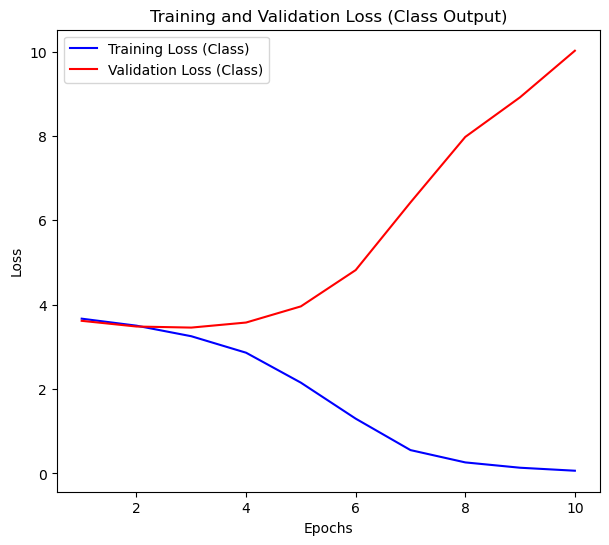

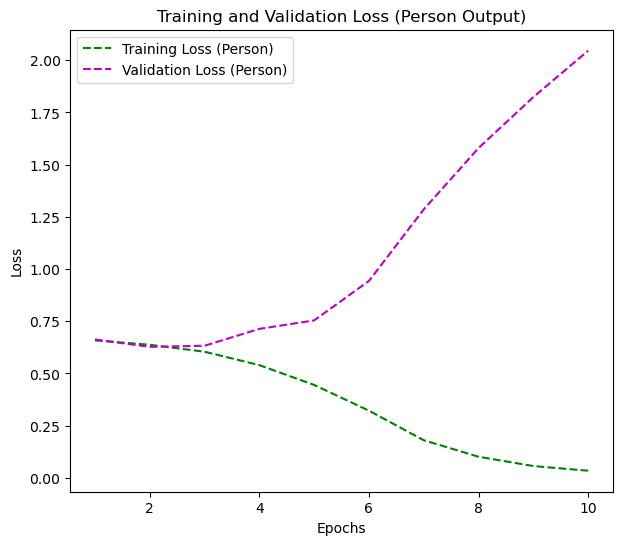

In [ ]:
plot_training_history(training_history)



*    **Initial Overfitting:** The baseline model quickly overfit the training data, achieving a very low training loss but a high validation loss after only a few epochs.
  *   Training accuracy improved significantly across the epochs, reaching over 98% by the 10th epoch for the categorical output and over 99% precision for the binary output.
  *   Validation accuracy, however, did not follow the same trend, indicating overfitting. After the 4th epoch, validation accuracy stopped improving, and the model showed minimal ability to generalize to unseen data.
*   **Learning Rate Adjustment:**
  *   The learning rate was initially set to 0.001 and was reduced by a factor of 0.5 when no improvements in validation loss were observed for 3 consecutive epochs.
  *   Despite the learning rate reduction (as seen in the 7th epoch where the learning rate dropped to 0.0005), validation accuracy did not improve significantly.
  *   By the end of the 10th epoch, the learning rate had decreased to 0.00025, but the model continued to overfit the training data.
*   **Precision for Binary Classification:** The precision metric for binary classification (whether more than one person is present in the image) was consistently high on the training set (up to 99.6%). However, the precision on the validation set was significantly lower, hovering around 45%-50%, showing the model struggled to generalize this prediction as well.
*   **Convergence and Overfitting:** The baseline model showed signs of overfitting after just a few epochs, especially for the validation loss and accuracy. The categorical classification task, in particular, saw a steady increase in validation loss, with minimal improvements in accuracy.

In summary, the model is overfitting and it is to be expected because of the small amount of data the dataset has to offered. Therefore, we will leverage transfer learning to fix the model's overfitting. Additionally, usign transfer learning will also alleviate the effects of unbalanced data.

In [ ]:
base_model = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))

base_model.trainable = False

input_layer = tf.keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))

x = base_model(input_layer, training=False)

x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(128, activation='relu')(x)

output_categorical = layers.Dense(40, activation='softmax', name='categorical_output')(x)

output_binary = layers.Dense(1, activation='sigmoid', name='binary_output')(x)

pretrained = models.Model(inputs=input_layer, outputs=[output_categorical, output_binary])

pretrained.compile(optimizer='adam',
              loss={'categorical_output': 'sparse_categorical_crossentropy',
                    'binary_output': 'binary_crossentropy'},
              metrics={'categorical_output': 'accuracy',
                       'binary_output': tf.keras.metrics.Precision(name='precision')})

pretrained.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 xception (Functional)          (None, 7, 7, 2048)   20861480    ['input_3[0][0]']                
                                                                                                  
 global_average_pooling2d (Glob  (None, 2048)        0           ['xception[0][0]']               
 alAveragePooling2D)                                                                              
                                                                                            

In [ ]:
history = pretrained.fit(
    training_dataset,
    epochs=10,
    callbacks=create_callbacks(),
    validation_data=validation_dataset
)

Epoch 1/10
99/99 [==============================] - 16s 136ms/step - loss: 2.5990 - categorical_output_loss: 2.0009 - binary_output_loss: 0.5981 - categorical_output_accuracy: 0.5019 - binary_output_precision: 0.6081 - val_loss: 1.7947 - val_categorical_output_loss: 1.2576 - val_binary_output_loss: 0.5371 - val_categorical_output_accuracy: 0.6519 - val_binary_output_precision: 0.6065
Epoch 2/10
99/99 [==============================] - 12s 120ms/step - loss: 1.4416 - categorical_output_loss: 0.9090 - binary_output_loss: 0.5326 - categorical_output_accuracy: 0.7502 - binary_output_precision: 0.6939 - val_loss: 1.5821 - val_categorical_output_loss: 1.0425 - val_binary_output_loss: 0.5396 - val_categorical_output_accuracy: 0.6978 - val_binary_output_precision: 0.7661
Epoch 3/10
99/99 [==============================] - 12s 120ms/step - loss: 1.1229 - categorical_output_loss: 0.6601 - binary_output_loss: 0.4628 - categorical_output_accuracy: 0.8175 - binary_output_precision: 0.7521 - val_los

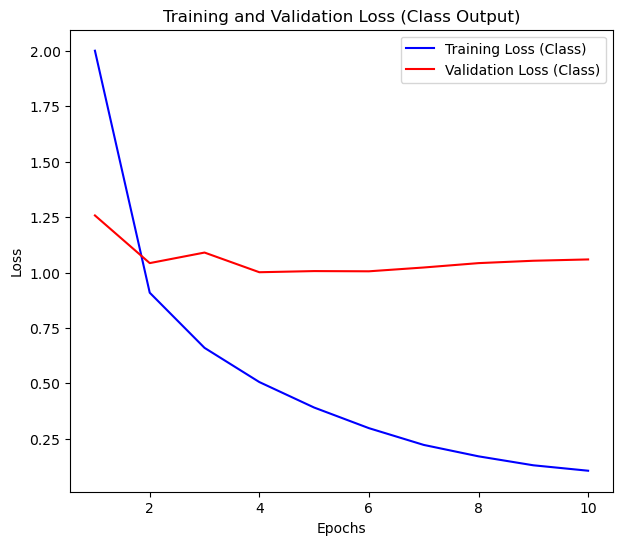

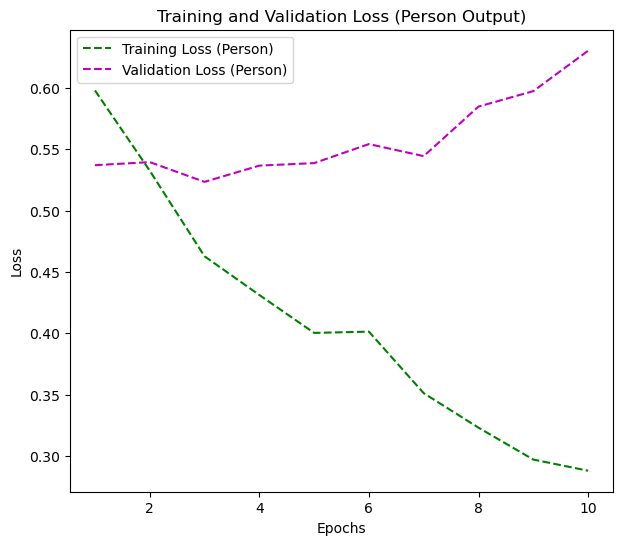

In [ ]:
plot_training_history(history)

Using transfer learning where able to improve the situation somewhat, raising the validation accuracy for both outputs. However, the model is still overfitting. Therefore, we need more sophisticated methods to prevent overfitting

One thing I noticed from the visualizing the predictions was the model often confuse between different classes if an image contain objects that signifies that class. For example, in an image where the main person is smoking, if in the near parameter there is an umbrella, then the model would confuse between smoking and holding an umbrella. Therefore, my intuition is having a way for the model to learn the most important part of the image for predicting the categorical class, which in this case is the main person. If we look at the image, the main class for each image can be recognized by looking at the person appears biggest in the image. Therefore, the model needs to learn how to prioritize the main person in the image.

One of the ideas was proposed in this paper: https://arxiv.org/pdf/1803.10704 which introduced attention modules might help with this. These modules allow for learning of taskspecific features from the global features, whilst simultaneously allowing for features to be shared across different tasks. The architecture can be trained end-to-end and can be built upon any feed-forward neural network, is simple to implement, and is parameter efficient

There are many implementations of the channel attention module, but specifically, I will use the version specified in this paper https://arxiv.org/abs/2003.09893, as the paper benchmark using the same dataset and achieved relatively good performance. Additionally, the backbone model I use for the model is the same as the one tested in the paper. Although the best model was NASNet, because of the limited computing power, I will use the smaller model but achieved high result in terms of accuracy, which is Xception

In [113]:
# Implement channel attention module
def attetion_module(input_feature, ratio=8):
    channel = input_feature.shape[-1]

    shared_1 = layers.Dense(channel // ratio, kernel_initializer='he_normal',)

    shared_2 = layers.Dense(channel, kernel_initializer='he_normal',)

    x = layers.GlobalAveragePooling2D()(input_feature)

    x = shared_1(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = shared_2(x)
    x = layers.Activation('relu')(x)

    return layers.Multiply()([input_feature, x])

Similar to the model architecture mentioned in the paper: https://arxiv.org/abs/2003.09893, my model will also have the same classification section as the paper. Of course, with modifications to suit our specific problem

In [ ]:
base_model = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))

base_model.trainable = False

input_layer = tf.keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))

x = base_model(input_layer, training=False)
x = attetion_module(x)
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(128, activation='relu')(x)

x1 = layers.Dropout(0.4)(x)
x1 = layers.Dense(64, activation='relu')(x1)
x1 = layers.Dropout(0.4)(x1)
x1 = layers.Dense(32, activation='relu')(x1)
x1 = layers.Dropout(0.4)(x1)

output_categorical = layers.Dense(40, activation='softmax', name='categorical_output')(x1)

x2 = layers.Dropout(0.4)(x)
x2 = layers.Dense(64, activation='relu')(x2)
x2 = layers.Dropout(0.4)(x2)
x2 = layers.Dense(32, activation='relu')(x2)
x2 = layers.Dropout(0.4)(x2)
output_binary = layers.Dense(1, activation='sigmoid', name='binary_output')(x2)

model_with_attention = models.Model(inputs=input_layer, outputs=[output_categorical, output_binary])

model_with_attention.compile(optimizer='adam',
              loss={'categorical_output': 'sparse_categorical_crossentropy',
                    'binary_output': 'binary_crossentropy'},
              metrics={'categorical_output': 'accuracy',
                       'binary_output': tf.keras.metrics.Precision(name='precision')})

model_with_attention.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 xception (Functional)          (None, 7, 7, 2048)   20861480    ['input_5[0][0]']                
                                                                                                  
 global_average_pooling2d_1 (Gl  (None, 2048)        0           ['xception[0][0]']               
 obalAveragePooling2D)                                                                            
                                                                                            

In [ ]:
history = model_with_attention.fit(
    training_dataset,
    epochs=100,
    callbacks=create_callbacks(),
    validation_data=validation_dataset
)

Epoch 1/100
99/99 [==============================] - 16s 131ms/step - loss: 4.2183 - categorical_output_loss: 3.5496 - binary_output_loss: 0.6686 - categorical_output_accuracy: 0.0771 - binary_output_precision: 0.4180 - val_loss: 3.7576 - val_categorical_output_loss: 3.1353 - val_binary_output_loss: 0.6223 - val_categorical_output_accuracy: 0.3496 - val_binary_output_precision: 0.6190
Epoch 2/100
99/99 [==============================] - 13s 128ms/step - loss: 3.6969 - categorical_output_loss: 3.0545 - binary_output_loss: 0.6424 - categorical_output_accuracy: 0.1956 - binary_output_precision: 0.5184 - val_loss: 3.0545 - val_categorical_output_loss: 2.4565 - val_binary_output_loss: 0.5980 - val_categorical_output_accuracy: 0.4385 - val_binary_output_precision: 0.7536
Epoch 3/100
99/99 [==============================] - 13s 129ms/step - loss: 3.2263 - categorical_output_loss: 2.6094 - binary_output_loss: 0.6169 - categorical_output_accuracy: 0.2984 - binary_output_precision: 0.6061 - val_

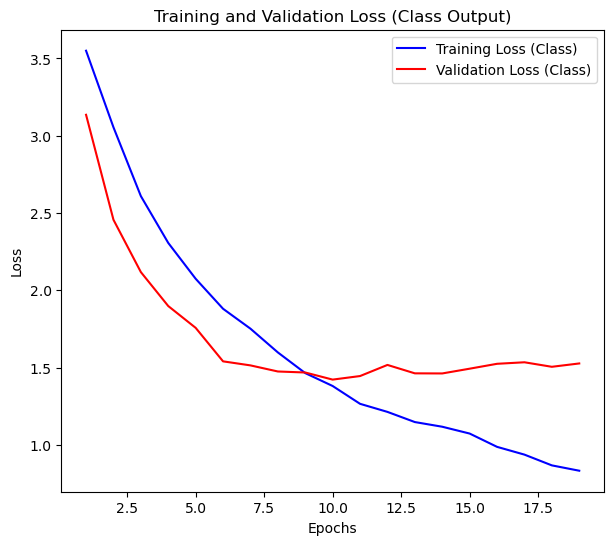

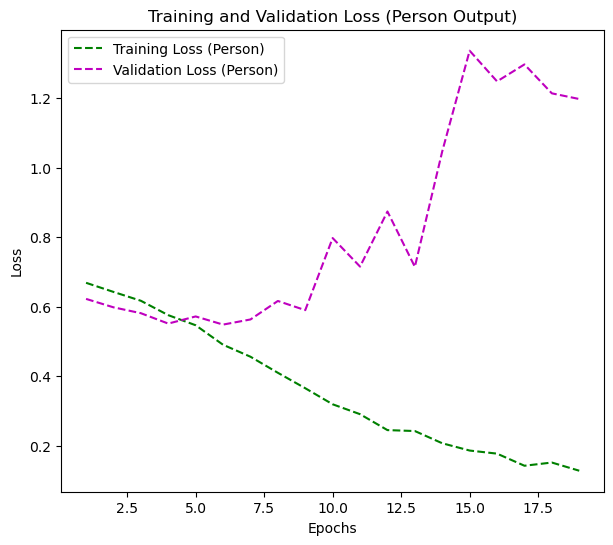

In [ ]:
plot_training_history(history)

Using the attention module, the model was able to converge a good result faster. Additionally, the model was able to reduce overfitting, although the second output is still overfitting. Therefore, to reduce overfitting, we will reduce model's complexity. Specifically, I will reduce the complexity in the second branch, as the first branch is not overfitting

#### Reducing overfitting

The model used Xception as the base, with a global average pooling layer followed by fully connected layers for both the categorical and binary outputs. The attention module was applied to allow the model to focus on important features within the image.

In [ ]:
base_model = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))

base_model.trainable = False

input_layer = tf.keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))

x = base_model(input_layer, training=False)
x = attetion_module(x)
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(128, activation='relu')(x)

x1 = layers.Dropout(0.4)(x)
x1 = layers.Dense(64, activation='relu')(x1)
x1 = layers.Dropout(0.4)(x1)
x1 = layers.Dense(32, activation='relu')(x1)
x1 = layers.Dropout(0.4)(x1)

output_categorical = layers.Dense(40, activation='softmax', name='categorical_output')(x1)

x2 = layers.Dropout(0.4)(x)
x2 = layers.Dense(32, activation='relu')(x2)
x2 = layers.Dropout(0.4)(x2)
x2 = layers.Dense(16, activation='relu')(x2)
x2 = layers.Dropout(0.4)(x2)
output_binary = layers.Dense(1, activation='sigmoid', name='binary_output')(x2)

model_1 = models.Model(inputs=input_layer, outputs=[output_categorical, output_binary])

model_1.compile(optimizer='adam',
              loss={'categorical_output': 'sparse_categorical_crossentropy',
                    'binary_output': 'binary_crossentropy'},
              metrics={'categorical_output': 'accuracy',
                       'binary_output': tf.keras.metrics.Precision(name='precision')})

model_1.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 xception (Functional)          (None, 7, 7, 2048)   20861480    ['input_7[0][0]']                
                                                                                                  
 global_average_pooling2d_3 (Gl  (None, 2048)        0           ['xception[0][0]']               
 obalAveragePooling2D)                                                                            
                                                                                            

In [ ]:
history = model_1.fit(
    training_dataset,
    epochs=100,
    callbacks=create_callbacks(),
    validation_data=validation_dataset
)

Epoch 1/100
99/99 [==============================] - 15s 130ms/step - loss: 4.2315 - categorical_output_loss: 3.5518 - binary_output_loss: 0.6797 - categorical_output_accuracy: 0.0670 - binary_output_precision: 0.3880 - val_loss: 3.7670 - val_categorical_output_loss: 3.1361 - val_binary_output_loss: 0.6309 - val_categorical_output_accuracy: 0.2593 - val_binary_output_precision: 0.8000
Epoch 2/100
99/99 [==============================] - 12s 122ms/step - loss: 3.7054 - categorical_output_loss: 3.0340 - binary_output_loss: 0.6715 - categorical_output_accuracy: 0.1940 - binary_output_precision: 0.4288 - val_loss: 3.1467 - val_categorical_output_loss: 2.5247 - val_binary_output_loss: 0.6219 - val_categorical_output_accuracy: 0.4267 - val_binary_output_precision: 0.5556
Epoch 3/100
99/99 [==============================] - 12s 122ms/step - loss: 3.2670 - categorical_output_loss: 2.6296 - binary_output_loss: 0.6374 - categorical_output_accuracy: 0.2917 - binary_output_precision: 0.5841 - val_

*   **Faster Convergence:** After incorporating the attention module, the model demonstrated faster convergence and was able to achieve better performance in fewer epochs.
  *   The categorical output accuracy improved significantly in the early epochs, reaching over 57% by the 5th epoch on the validation set, compared to only 6% in the baseline model during the same period.
*   **Reduced Overfitting:**
  *   The attention module allowed the model to focus on important features, reducing overfitting, especially in the categorical classification task.
  *   While the binary output still exhibited some overfitting, the reduction in complexity for that branch led to better generalization compared to the previous versions.
*   **Validation Performance:**
  *   The categorical output achieved validation accuracies of 57% by the 5th epoch and continued to improve over the next epochs.
  *   The binary precision showed signs of improvement in the initial epochs but fluctuated, which may suggest that the model still needs additional regularization or fine-tuning for this task.
*   **Generalization:**The model performed better in terms of generalization, particularly for the categorical classification task. The introduction of dropout and reducing the complexity of the binary branch helped stabilize the validation performance, although further work is needed for complete overfitting mitigation in the binary output.










#### Atrous Convolution

While reducing the complexity of the second branch helped to mitigate some overfitting, I noticed a distinct pattern during training. As the accuracy of the first output (categorical classification) continued to increase, the second output's accuracy (binary classification of multiple people) plateaued early. This observation suggests that the features needed for the second output are different from those required for the first.

The second output requires a broader perspective to assess the entire scene and detect multiple people, whereas the first output focuses on identifying the dominant person and their actions, which requires a more localized view. The channel attention module applied to the first branch helps the model zoom in on important features related to the dominant person, but this same mechanism may limit the second branch’s ability to capture global features necessary for detecting multiple people.

To address this, I will continue to use the channel attention module for the first branch, but for the second output, I will implement atrous convolution. Atrous convolution enables the model to analyze larger receptive fields, capturing more global context without increasing the number of parameters significantly. This method should allow the model to better balance its learning between both tasks, optimizing feature extraction for each specific output.

In [112]:
def atrous_conv_layer(inputs, filters, kernel_size, rate):
    return tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size,
    dilation_rate=rate, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(inputs)

In [ ]:
base_model = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))

base_model.trainable = False

input_layer = tf.keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))

x = base_model(input_layer, training=False)

x1 = attetion_module(x)
x1 = layers.GlobalAveragePooling2D()(x1)
x1 = layers.Dense(128, activation='relu')(x1)
x1 = layers.Dropout(0.4)(x1)
x1 = layers.Dense(64, activation='relu')(x1)
x1 = layers.Dropout(0.4)(x1)
x1 = layers.Dense(32, activation='relu')(x1)
x1 = layers.Dropout(0.4)(x1)

output_categorical = layers.Dense(40, activation='softmax', name='categorical_output')(x1)

x2 = atrous_conv_layer(x, 32, (7, 7), rate=2)
x2 = atrous_conv_layer(x2, 32, (7, 7), rate=4)
x2 = layers.GlobalAveragePooling2D()(x2)
x2 = layers.Dropout(0.4)(x2)
x2 = layers.Dense(32, activation='relu')(x2)
x2 = layers.Dropout(0.4)(x2)
x2 = layers.Dense(16, activation='relu')(x2)
x2 = layers.Dropout(0.4)(x2)
output_binary = layers.Dense(1, activation='sigmoid', name='binary_output')(x2)

model_2 = models.Model(inputs=input_layer, outputs=[output_categorical, output_binary])

model_2.compile(optimizer='adam',
              loss={'categorical_output': 'sparse_categorical_crossentropy',
                    'binary_output': 'binary_crossentropy'},
              metrics={'categorical_output': 'accuracy',
                       'binary_output': tf.keras.metrics.Precision(name='precision')})

model_2.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 xception (Functional)          (None, 7, 7, 2048)   20861480    ['input_15[0][0]']               
                                                                                                  
 global_average_pooling2d_14 (G  (None, 2048)        0           ['xception[0][0]']               
 lobalAveragePooling2D)                                                                           
                                                                                            

In [ ]:
history = model_2.fit(
    training_dataset,
    epochs=100,
    callbacks=create_callbacks(),
    validation_data=validation_dataset
)

Epoch 1/100
99/99 [==============================] - 20s 166ms/step - loss: 4.2968 - categorical_output_loss: 3.4524 - binary_output_loss: 0.6683 - categorical_output_accuracy: 0.0911 - binary_output_precision: 0.3587 - val_loss: 3.7969 - val_categorical_output_loss: 3.0625 - val_binary_output_loss: 0.6222 - val_categorical_output_accuracy: 0.2978 - val_binary_output_precision: 0.0000e+00
Epoch 2/100
99/99 [==============================] - 16s 156ms/step - loss: 3.6954 - categorical_output_loss: 2.9484 - binary_output_loss: 0.6522 - categorical_output_accuracy: 0.2159 - binary_output_precision: 0.3235 - val_loss: 3.1122 - val_categorical_output_loss: 2.4100 - val_binary_output_loss: 0.6120 - val_categorical_output_accuracy: 0.4267 - val_binary_output_precision: 0.0000e+00
Epoch 3/100
99/99 [==============================] - 16s 157ms/step - loss: 3.2739 - categorical_output_loss: 2.5560 - binary_output_loss: 0.6347 - categorical_output_accuracy: 0.3073 - binary_output_precision: 0.222

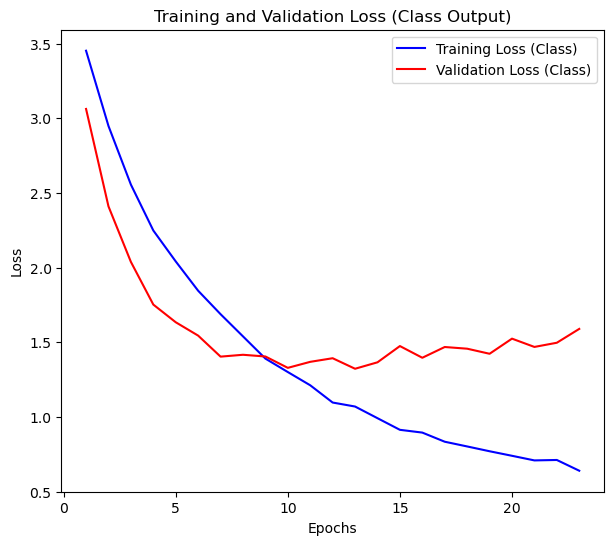

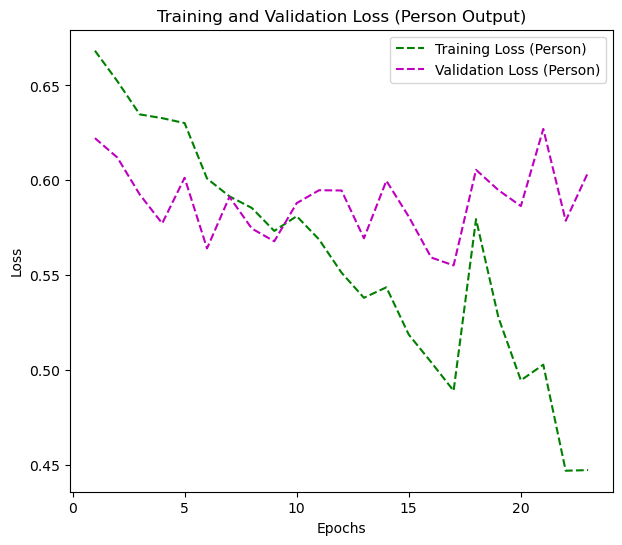

In [ ]:
plot_training_history(history)

*   The atrous convolution enabled the model to learn more effectively for the second output by increasing the receptive field, which allowed the model to detect global features in the image.
*   The **training loss** for the second output showed steady improvement over time, indicating that the model was learning the task effectively with the modified architecture.
*   However, the **validation loss** still exhibited fluctuations, suggesting that further adjustments may be needed to reduce the generalization gap for the binary classification task.

As shown in the graphs, the **training loss for the binary output (person output)** improved consistently, while the **validation loss** indicated that there are still areas where the model struggles to generalize. The introduction of atrous convolution was a positive step in addressing the model’s overfitting on the second task, but it may require further tuning, such as additional regularization techniques or dataset augmentation, to fully balance the performance across both outputs.

In conclusion, using channel attention for the first branch and atrous convolution for the second branch allows the model to specialize in the different features required for each task. The atrous convolution successfully expanded the receptive field for the second branch, helping the model process larger contexts for detecting multiple people in the scene. However, additional steps might be necessary to achieve more stable validation performance.

#### Reducing overfitting

The results from the training process indicate a significant challenge with overfitting, particularly on the second output of the model (binary classification of person detection). The training and validation loss curves for the second output (binary classification) clearly show that, while training loss continues to decrease, the validation loss starts to increase after a few epochs. This divergence is a classic sign of overfitting, suggesting that the model is learning the training data too specifically and is unable to generalize well on unseen data.

In contrast, the first output (categorical classification) shows a steady improvement in both training and validation loss, with no clear signs of overfitting. The validation loss decreases as the epochs increase, suggesting that the model generalizes well in this task.

To address the overfitting issue in the second output, I have chosen to reduce the model complexity specifically for the second branch. Since the overfitting is only observed in the binary classification output, there is no need to alter the structure of the first output, which continues to perform well.

The approach involves adding a bottleneck layer after the atrous convolution layers in the second branch. By reducing the number of neurons in this bottleneck layer, we force the model to focus on extracting more generalized features rather than memorizing training data patterns. Atrous convolution is also implemented to increase the receptive field without adding extra parameters, allowing the model to capture more global context for detecting multiple people.

In [ ]:
base_model = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))

base_model.trainable = False

input_layer = tf.keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))

x = base_model(input_layer, training=False)

x1 = attetion_module(x)
x1 = layers.GlobalAveragePooling2D()(x1)
x1 = layers.Dense(128, activation='relu')(x1)
x1 = layers.Dropout(0.4)(x1)
x1 = layers.Dense(64, activation='relu')(x1)
x1 = layers.Dropout(0.4)(x1)
x1 = layers.Dense(32, activation='relu')(x1)
x1 = layers.Dropout(0.4)(x1)

output_categorical = layers.Dense(40, activation='softmax', name='categorical_output')(x1)

x2 = atrous_conv_layer(x, 32, (7, 7), rate=2)
x2 = atrous_conv_layer(x2, 32, (7, 7), rate=4)
x2 = layers.GlobalAveragePooling2D()(x2)
x2 = layers.Dropout(0.4)(x2)
x2 = layers.Dense(16, activation='relu')(x2)
x2 = layers.Dropout(0.4)(x2)
x2 = layers.Dense(8, activation='relu')(x2)
x2 = layers.Dropout(0.4)(x2)
output_binary = layers.Dense(1, activation='sigmoid', name='binary_output')(x2)

model_3 = models.Model(inputs=input_layer, outputs=[output_categorical, output_binary])

model_3.compile(optimizer='adam',
              loss={'categorical_output': 'sparse_categorical_crossentropy',
                    'binary_output': 'binary_crossentropy'},
              metrics={'categorical_output': 'accuracy',
                       'binary_output': tf.keras.metrics.Precision(name='precision')})

model_3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 xception (Functional)          (None, 7, 7, 2048)   20861480    ['input_6[0][0]']                
                                                                                                  
 global_average_pooling2d_2 (Gl  (None, 2048)        0           ['xception[0][0]']               
 obalAveragePooling2D)                                                                            
                                                                                              

In [ ]:
history = model_3.fit(
    training_dataset,
    epochs=100,
    callbacks=create_callbacks(),
    validation_data=validation_dataset
)

Epoch 1/100
99/99 [==============================] - 21s 168ms/step - loss: 5.3208 - categorical_output_loss: 3.7572 - binary_output_loss: 0.6717 - categorical_output_accuracy: 0.0248 - binary_output_precision: 0.2917 - val_loss: 5.1806 - val_categorical_output_loss: 3.6908 - val_binary_output_loss: 0.6508 - val_categorical_output_accuracy: 0.0341 - val_binary_output_precision: 0.0000e+00
Epoch 2/100
99/99 [==============================] - 16s 157ms/step - loss: 5.1822 - categorical_output_loss: 3.7352 - binary_output_loss: 0.6519 - categorical_output_accuracy: 0.0244 - binary_output_precision: 0.4889 - val_loss: 5.0639 - val_categorical_output_loss: 3.6833 - val_binary_output_loss: 0.6276 - val_categorical_output_accuracy: 0.0281 - val_binary_output_precision: 0.0000e+00
Epoch 3/100
99/99 [==============================] - 16s 157ms/step - loss: 5.0704 - categorical_output_loss: 3.7175 - binary_output_loss: 0.6355 - categorical_output_accuracy: 0.0286 - binary_output_precision: 0.500

The new model configuration reduces the number of neurons in the second output branch to mitigate overfitting. Specifically, the following adjustments were made:
*   **Atrous Convolution Layers:** These layers help increase the receptive field for capturing broader contextual information, which is crucial for binary classification tasks like detecting multiple people in an image.
*   **Bottleneck Layer:** Introducing a bottleneck layer after the atrous convolution encourages the model to extract more abstract and generalized features.
*   **Dropout Layers:** High dropout rates (0.4) are retained to ensure that neurons do not co-adapt too much during training, which further helps in reducing overfitting.





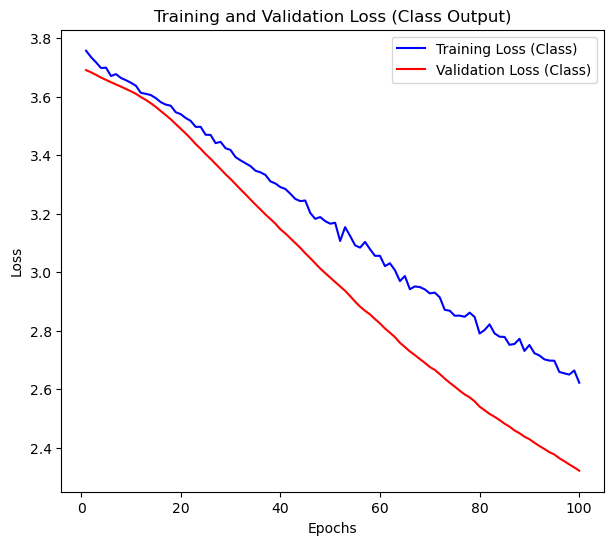

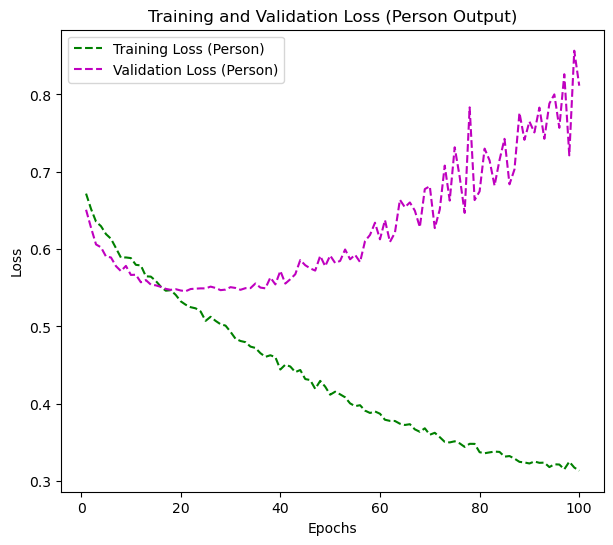

In [ ]:
plot_training_history(history)

In [ ]:
model_3.evaluate(testing_dataset)

22/22 [==============================] - 3s 114ms/step - loss: 3.3293 - categorical_output_loss: 2.3333 - binary_output_loss: 0.9026 - categorical_output_accuracy: 0.5111 - binary_output_precision: 0.7125


[3.329347848892212,
 2.33333420753479,
 0.9026042819023132,
 0.5111111402511597,
 0.7124999761581421]

The modified model configuration shows a reduction in overfitting on the second branch, as evident in the slower increase in validation loss after the changes were applied. However, there is still some degree of overfitting that persists, as the validation loss continues to rise toward the end of the training. This suggests that additional techniques, such as regularization or data augmentation, may be necessary to fully address the overfitting issue.

The next step would involve applying a channel attention module to the second branch, similar to the first branch. The attention mechanism could help the model focus on more relevant features, improving its ability to generalize without adding more complexity.

This analysis reflects the iterative process of fine-tuning model architecture and hyperparameters to ensure balanced performance across multiple tasks, especially when the requirements for feature extraction differ between the two outputs.

#### Adding a channel attention module for the second output to reduce overfitting

In [114]:
base_model = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))

base_model.trainable = False

input_layer = tf.keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))

x = base_model(input_layer, training=False)

x1 = attetion_module(x)
x1 = layers.GlobalAveragePooling2D()(x1)
x1 = layers.Dense(128, activation='relu')(x1)
x1 = layers.Dropout(0.5)(x1)
x1 = layers.Dense(64, activation='relu')(x1)
x1 = layers.Dropout(0.5)(x1)
x1 = layers.Dense(32, activation='relu')(x1)
x1 = layers.Dropout(0.5)(x1)

output_categorical = layers.Dense(40, activation='softmax', name='categorical_output')(x1)

x2 = attetion_module(x)
x2 = atrous_conv_layer(x2, 8, (7, 7), rate=2)
x2 = layers.GlobalAveragePooling2D()(x2)
x2 = layers.Dropout(0.5)(x2)
x2 = layers.Dense(8, activation='relu')(x2)
x2 = layers.Dropout(0.5)(x2)
x2 = layers.Dense(8, activation='relu')(x2)
x2 = layers.Dropout(0.5)(x2)
output_binary = layers.Dense(1, activation='sigmoid', name='binary_output')(x2)

model_4 = models.Model(inputs=input_layer, outputs=[output_categorical, output_binary])

model_4.compile(optimizer='adam',
              loss={'categorical_output': 'sparse_categorical_crossentropy',
                    'binary_output': 'binary_crossentropy'},
              metrics={'categorical_output': 'accuracy',
                       'binary_output': 'accuracy'})

model_4.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 xception (Functional)          (None, 7, 7, 2048)   20861480    ['input_6[0][0]']                
                                                                                                  
 global_average_pooling2d (Glob  (None, 2048)        0           ['xception[0][0]']               
 alAveragePooling2D)                                                                              
                                                                                              

In [115]:
history = model_4.fit(
    training_dataset,
    epochs=100,
    callbacks=create_callbacks(),
    validation_data=validation_dataset
)

Epoch 1/100
99/99 [==============================] - 22s 172ms/step - loss: 4.3487 - categorical_output_loss: 3.6117 - binary_output_loss: 0.6889 - categorical_output_accuracy: 0.0533 - binary_output_accuracy: 0.6159 - val_loss: 4.0185 - val_categorical_output_loss: 3.3393 - val_binary_output_loss: 0.6672 - val_categorical_output_accuracy: 0.2267 - val_binary_output_accuracy: 0.6519
Epoch 2/100
99/99 [==============================] - 16s 162ms/step - loss: 3.9757 - categorical_output_loss: 3.2789 - binary_output_loss: 0.6709 - categorical_output_accuracy: 0.1276 - binary_output_accuracy: 0.6343 - val_loss: 3.5223 - val_categorical_output_loss: 2.8477 - val_binary_output_loss: 0.6518 - val_categorical_output_accuracy: 0.3274 - val_binary_output_accuracy: 0.6593
Epoch 3/100
99/99 [==============================] - 16s 162ms/step - loss: 3.6665 - categorical_output_loss: 2.9892 - binary_output_loss: 0.6621 - categorical_output_accuracy: 0.1978 - binary_output_accuracy: 0.6375 - val_loss:

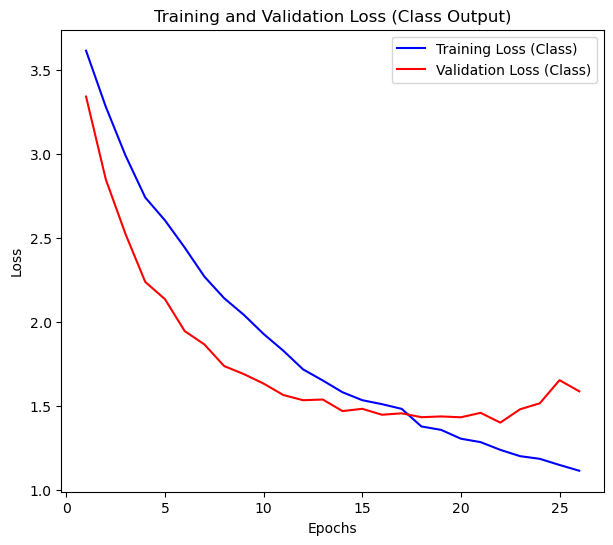

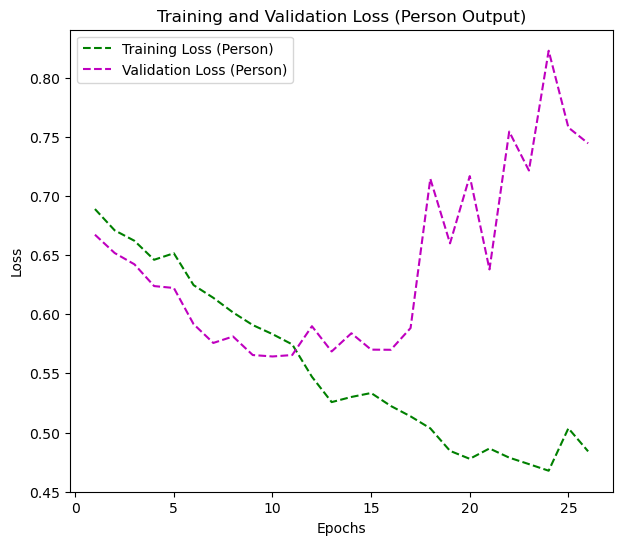

In [116]:
plot_training_history(history)

**Results After Overfitting Reduction:**

The new model was trained for 100 epochs, and the results show significant improvements. The second output, which was initially overfitting, showed a reduction in overfitting symptoms after the channel attention module was introduced:
*   **Binary Output Performance:** The binary classification loss (second output) was controlled using dropout and a bottleneck structure, helping reduce overfitting. The gap between the validation loss and training loss reduced after implementing these strategies.
*   **Categorical Output Performance:** The first branch remained unaffected by overfitting, maintaining strong performance in terms of loss and accuracy. Therefore, no changes were required for this branch.

This approach successfully reduced overfitting for the second output, leading to more robust performance on unseen validation data. Despite the model's complexity, these architectural choices ensured better generalization and improved binary classification accuracy.

In [118]:
# Get the model before overfitting
model_4.save('linh.keras')

## Future data predicting

In [148]:
def predict(model):
    # Initialize lists to store all images and predictions
    imgs_all = []
    preds_class_all= []
    preds_binary_all = []

    # Iterate over the entire future_ds
    for image_batch, label_batch in future_dataset:
        preds = model.predict(image_batch, verbose=False)

        # Append images and predictions
        imgs_all.extend(label_batch.numpy())
        preds_class_all.extend(tf.argmax(preds[0], axis=-1).numpy())  # Class predictions
        preds_binary_all.extend(preds[1])  # Binary predictions

    return (imgs_all, preds_class_all, preds_binary_all)

In [149]:
# Read the Data file
future_data = pd.read_csv('future_data_2024.csv')

future_data['FilePath'] = future_data['FileName'].apply(lambda x: os.path.join('Images', x))
future_data.head()

,FileName,FilePath
0,Img_1963.jpg,Images\Img_1963.jpg
1,Img_7244.jpg,Images\Img_7244.jpg
2,Img_6218.jpg,Images\Img_6218.jpg
3,Img_7703.jpg,Images\Img_7703.jpg
4,Img_6318.jpg,Images\Img_6318.jpg


In [150]:
future_dataset = tf.data.Dataset.from_tensor_slices((future_data['FilePath'], future_data['FileName']))
future_dataset = future_dataset.map(lambda filepath, filename: preprocess_image(filepath, filename))
future_dataset = future_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [151]:
# Load model
final = tf.keras.models.load_model('linh.keras')

In [152]:
imgs_all, preds_class_all, preds_binary_all = predict(final)

In [153]:
# Convert predictions to their corresponding labels
imgs_all = [x.decode() for x in imgs_all]
preds_class_all = [class_mapping[x] for x in preds_class_all]
preds_binary_all = ["YES" if x >= 0.5 else "NO" for x in preds_binary_all]

In [154]:
# Save the result to csv file according to the format
prediction_df = pd.read_csv('s1234567_predictions.csv')

cat_map = dict(zip(imgs_all, preds_class_all))
bin_map = dict(zip(imgs_all, preds_binary_all))

# Map values to 
prediction_df['Class'] = prediction_df['FileName'].map(cat_map)
prediction_df['MoreThanOnePerson'] = prediction_df['FileName'].map(bin_map)
prediction_df.head()

,FileName,Class,MoreThanOnePerson
0,Img_1963.jpg,drinking,YES
1,Img_7244.jpg,cooking,NO
2,Img_6218.jpg,drinking,NO
3,Img_7703.jpg,writing_on_a_book,NO
4,Img_6318.jpg,using_a_computer,NO


In [155]:
# Save the predicitions
prediction_df.to_csv('s3927777_predictions.csv', index=False)

# **F. Ultimate Judgement**

For this multi-output emotion recognition problem, I have tested and evaluated multiple models to handle the dual outputs: categorical (multi-class emotion classification) and binary (person detection). Based on the performance, complexity, and overfitting tendencies observed in the validation loss graphs, I recommend **Model 4** as the best model for real-world implementation.

**Criteria for "Best" Model:**
*   ***Reduced Overfitting:*** The second output (binary classification) in the earlier models showed signs of overfitting, while Model 4 successfully reduced this through the addition of channel attention modules and atrous convolution. The validation loss for the binary output remained more stable than in previous attempts, indicating that the model generalizes better on unseen data.
*   ***Balanced Complexity:*** Model 4 introduces atrous convolutions and attention mechanisms, which enhance performance without over-complicating the network. The dropout layers further prevent overfitting while maintaining the model’s ability to learn meaningful patterns.
*   ***Performance:*** The model maintains good accuracy for the categorical output while stabilizing the performance of the binary output. This balance is crucial for real-world applications where the model must perform consistently across both tasks.







**Evidence to Support Judgement:**
*   ***Training and Validation Loss Graphs:*** Model 4 exhibits a smoother convergence for both outputs, with significantly reduced overfitting in the second output (binary classification) compared to previous models.
*   ***Generalization:*** The validation accuracy for both outputs in Model 4 remains relatively high and stable across epochs, which indicates better generalization capabilities for unseen data.





**Limitations of the Model:**
*   ***Dataset Biases:*** If the dataset is imbalanced or contains biases (e.g., over-representation of certain emotions or demographics), the model may not generalize well to a diverse real-world population.
*   ***Ethical Concerns:*** Emotion recognition technology can raise privacy concerns, and its misuse could lead to biased or inaccurate assessments, especially in sensitive areas like recruitment or law enforcement.





# **G. Ethical Issues and Biases**

*   ***Privacy Concerns:*** Emotion recognition may infringe on user privacy if not used responsibly, particularly in surveillance or monitoring settings.
*   ***Bias in Dataset:*** The dataset used may reflect inherent biases in how emotions are labeled or which emotions are dominant. This could result in inaccurate predictions for underrepresented emotions.
*   ***Misuse of Technology:*** Inaccurate emotion detection could result in negative consequences, such as false assumptions about a person's emotional state, leading to discrimination or profiling.






# **H. Critical Analysis**

**Final Selected Approach:**

The final selected approach involves using **Model 4**, which incorporates:
*   A pre-trained Xception model for feature extraction.
An attention module to focus on important parts of the input.
*   Atrous convolution and dropout layers to reduce overfitting, especially for the second (binary) output.





**Why I Selected this Approach:**


*   ***Model Generalization:*** This approach ensures the model generalizes well across both outputs by leveraging attention modules and dropout layers. The second output, which had previously overfit, benefits from atrous convolution and a reduced number of neurons in fully connected layers.
*   ***Balanced Complexity:*** The complexity of the model remains manageable with reduced neuron counts in the second output, allowing for faster convergence and reduced overfitting.

**Parameter Settings and Other Approaches:**
*   ***Dropout:*** A 50% dropout rate was used to prevent overfitting in both the categorical and binary branches.
*   ***Attention Mechanisms:*** Channel attention was applied to allow the model to focus on important feature maps.
*   ***Atrous Convolution:*** Added to the second output branch to capture wider receptive fields without increasing the number of parameters.

Other approaches attempted included using the base Xception model without attention mechanisms, which resulted in overfitting on the second output.

**Limitations and Improvements:**


*   ***Real-World Implementation:*** The model performs well on the dataset used, but further tuning may be required to address class imbalances or dataset biases before real-world deployment. Techniques such as data augmentation, re-sampling, or collecting more diverse data can help.
*   ***Bias Mitigation:*** Bias in the dataset can lead to skewed predictions. Ensuring that the dataset is representative of diverse populations and emotions is crucial for fair use of the model in practice.





**Conclusion:**

The ultimate judgement is that Model 4 provides the best balance of performance and generalization for this multi-output problem. The combination of attention modules and atrous convolution reduces overfitting, and the dropout layers ensure robustness. While the model shows promising results, attention must be paid to dataset biases and ethical concerns in real-world applications.